In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [2]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [3]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [4]:
# Load all of the data

def load_dataset(question,answer):
    
    data_dir = 'output_files/{}/{}/'.format(question,answer)
    
    bins = Table.read(data_dir+'bins.fits')
    debiased = Table.read(data_dir+'debiased.fits')
    fit_results = Table.read(data_dir+'fit_results.fits')
    vbins_table = Table.read(data_dir+'vbin_parameters.fits')
    all_bins = Table.read(data_dir+'all_bins.fits')
    fit_setup = pickle.load(open(data_dir+'fit_setup.p', "rb" ))
    
    return bins,all_bins,debiased,fit_results,vbins_table,fit_setup


def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction',sharex=True,sharey=True,stack=False):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    
    if stack == True:
        fig,axes = plt.subplots(n_morph,1,sharex=sharex,sharey=sharey,figsize=(10,3*n_morph))
    else:
        fig,axes = plt.subplots(y_dimension,x_dimension,sharex=sharex,sharey=sharey,figsize=(5*x_dimension
                                                                                             ,5*y_dimension))
        if n_morph >= 3:
            for ax in axes[-1,:]:
                ax.set_xlabel(xlabel)
            for ax in axes[:,0]:
                ax.set_ylabel(ylabel) 
        else:
            axes[0].set_xlabel(xlabel)
            axes[0].set_ylabel(ylabel)
            axes[1].set_xlabel(xlabel)
        axes=axes.ravel()
        for m in remove_axes:
            fig.delaxes(axes[m])
    
    plt.subplots_adjust(hspace=0,wspace=0)

    return fig,axes


def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh'
    else:
        suffix = '_debiased_rh_normalised'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
        
        select = np.ones(len(data_reduced)) == 1
    
    return data_reduced,select

In [5]:
question = 't01_smooth_or_features'
#question = 't02_edgeon'
#question = 't04_spiral'
#question = 't11_arms_number'

answers = questions[question]['answers']
answerlabels = questions[question]['answerlabels']

reference_answer = answers[0]

data,select = reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5)
#debiased_values = Table.read('output_files/' + question + '/' + answer + '/debiased.fits')

Primary question, so all 228201 galaxies used.


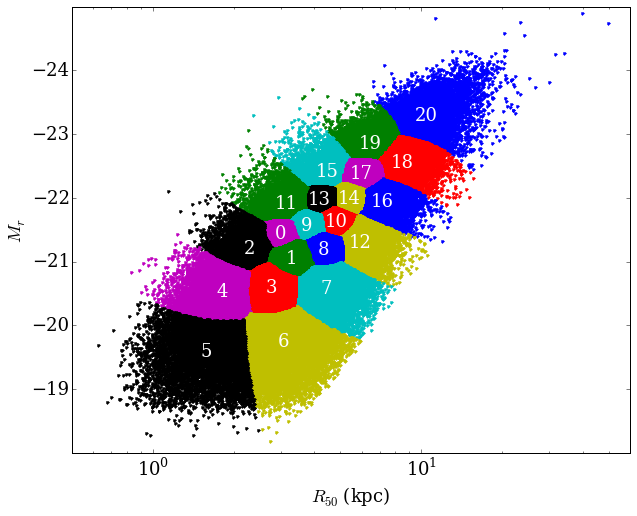

In [6]:
################ Voronoi bin plot ###################

bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,reference_answer)

vbins = all_bins['vbin']
Mr = full_data['PETROMAG_MR']
R50 = full_data['PETROR50_R_KPC']

relative_r = [((T-T.min())/(T.max()-T.min())) for T in [np.log10(vbins_table['R50']),vbins_table['Mr']]]
relative_r = relative_r[1]
r_sort = np.argsort(relative_r) # Trying to get neighbouring bins in different colours.

for v in np.unique(vbins)[r_sort]:
    inbin = vbins == v
    plt.plot(full_data['PETROR50_R_KPC'][inbin],full_data['PETROMAG_MR'][inbin], '.')
    
for v in range(len(vbins_table)):
    x_text_pos = 10**(vbins_table['R50'][v])
    y_text_pos = vbins_table['Mr'][v]
    plt.text(x_text_pos,y_text_pos,'{}'.format(v),
             color='w',horizontalalignment='center',
             verticalalignment='center')

    plt.ylabel(r"$M_r$")
    plt.xlabel(r"$R_{50}$ (kpc)")
    plt.xscale('log')

    _ = plt.axis((0.5, 60, -18, -25))

[3.3036227417897277, 7.1002826552566711, 0.15465182474378922, 10.000000000000002]
[0.14867213340082552, 1.0452601512281452, 0.67257910995247594, 1.4539444058016711]


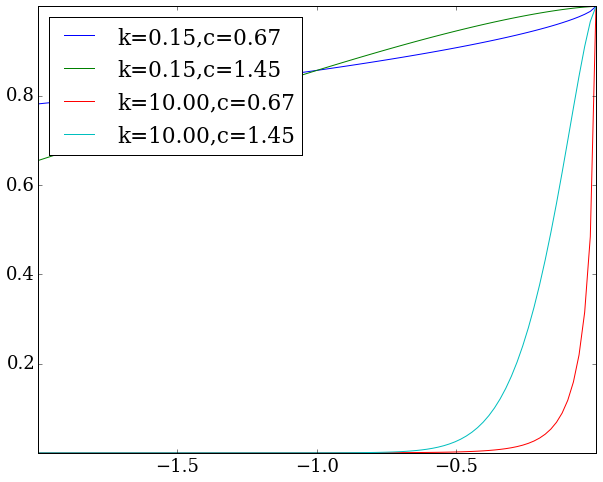

In [7]:
import make_dictionaries

k_vals = fit_results['k']
c_vals = fit_results['c']

k_range = [np.min(k_vals),np.max(k_vals)]
c_range = [np.min(c_vals),np.max(c_vals)]

functions = make_dictionaries.function_dictionary
f = functions['func'][1]
xg = np.linspace(-2,0,100)

for k in k_range:
    for c in c_range:
        plt.plot(xg,f(xg,k,c),label='k={0:.2f}'.format(k)+',c={0:.2f}'.format(c))

plt.legend(loc=2)

#_ = plt.hist(k_vals)
#_ = plt.hist(c_vals)

k_params = [np.std(k_vals),np.mean(k_vals),np.min(k_vals),np.max(k_vals)]
c_params = [np.std(c_vals),np.mean(c_vals),np.min(c_vals),np.max(c_vals)]
print(k_params)
print(c_params)

In [8]:
k_vals = fit_results['k']
c_vals = fit_results['c']
k_fits = fit_results['kf']
c_fits = fit_results['cf']
colors = fit_results['redshift']

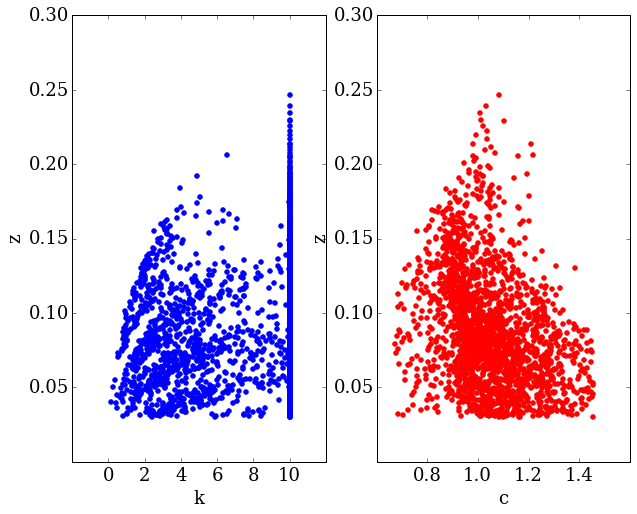

In [9]:
plt.subplot(1,2,1)
plt.scatter(k_vals,colors,color='b')
plt.xlabel('k')
plt.ylabel('z')
plt.subplot(1,2,2)
plt.scatter(c_vals,colors,color='r')
plt.xlabel('c')
plt.ylabel('z')

In [10]:
def normalise(data):
    
    mean_val = np.mean(data)
    std_val = np.std(data)
    normed = (data-mean_val)/std_val
    
    return normed

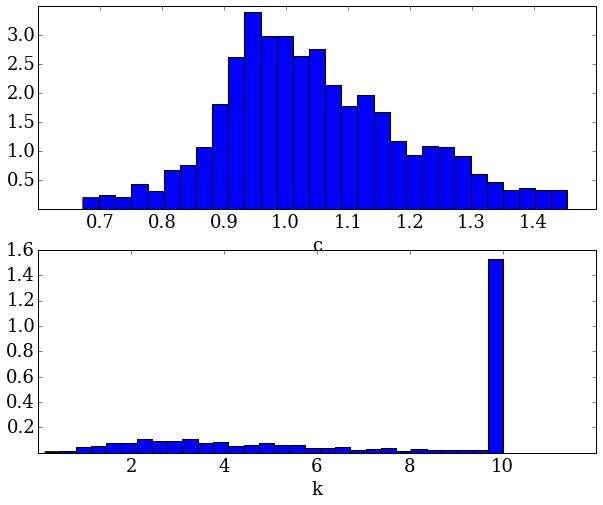

In [11]:
plt.subplot(2,1,1)
plt.hist(c_vals,bins=30,normed=True)
plt.xlabel('c')
plt.subplot(2,1,2)
plt.hist(k_vals,bins=30,normed=True)
plt.xlabel('k')

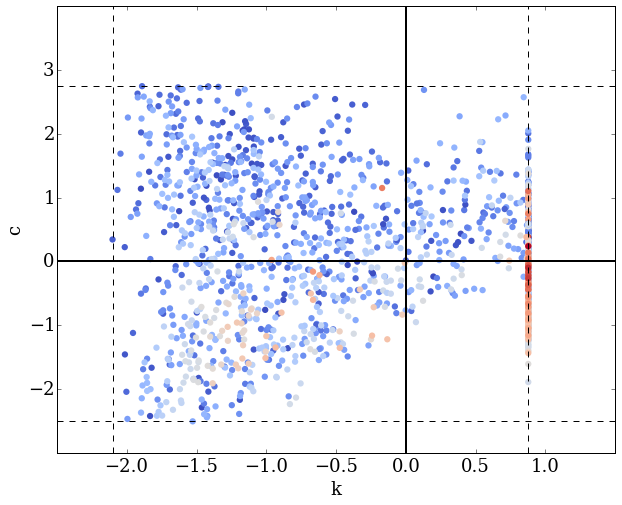

In [12]:
k_norm = normalise(k_vals)
c_norm = normalise(c_vals)

plt.scatter(k_norm,c_norm,c=colors,cmap=plt.cm.coolwarm,marker='o',s=40,lw=0)
#plt.scatter(k_fits,c_fits,color='k',alpha=0.5)
plt.xlabel('k')
plt.ylabel('c')

k_mean = np.mean(k_norm)
c_mean = np.mean(c_norm)
k_std = np.std(k_norm)
c_std = np.std(c_norm)

axes = plt.gca()

xmin,xmax = axes.get_xlim()
ymin,ymax = axes.get_ylim()

plt.axis([xmin,xmax,ymin,ymax])

plt.hlines(c_mean,xmin,xmax,linestyle='solid',linewidth=2)
plt.vlines(k_mean,ymin,ymax,linestyle='solid',linewidth=2)
'''
plt.hlines(c_mean+2*c_std,xmin,xmax,linestyle='dashed',linewidth=2)
plt.vlines(k_mean+2*k_std,ymin,ymax,linestyle='dashed',linewidth=2)
plt.hlines(c_mean-2*c_std,xmin,xmax,linestyle='dashed',linewidth=2)
plt.vlines(k_mean-2*k_std,ymin,ymax,linestyle='dashed',linewidth=2)
'''
# 'unclipped' lower + upper limits
plt.hlines(np.min(c_norm),xmin,xmax,linestyle='dashed')
plt.hlines(np.max(c_norm),xmin,xmax,linestyle='dashed')
plt.vlines(np.min(k_norm),ymin,ymax,linestyle='dashed')
plt.vlines(np.max(k_norm),ymin,ymax,linestyle='dashed')

(0, 1)

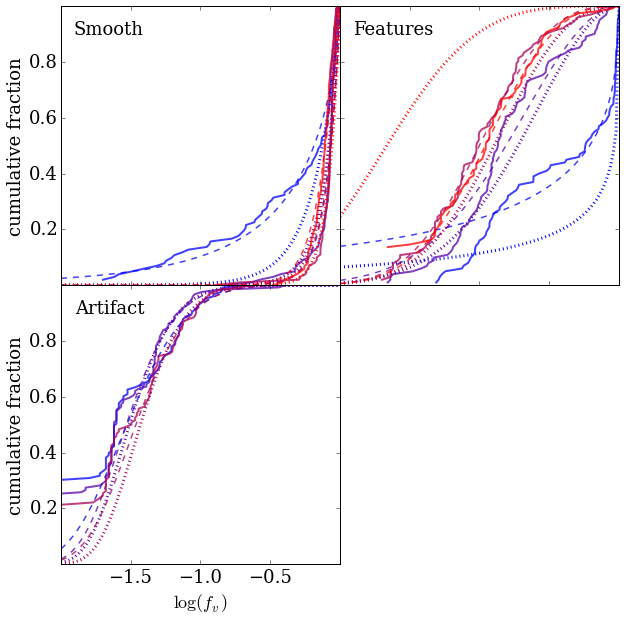

In [13]:
############### Example bin fitting plots ####################

max_bins_to_plot = 4 # number of bins to plot
v = 0 # plot this bin as an example

# make colour array of blue -> red:
colour_array = np.zeros((max_bins_to_plot,3))
colour_array[:,1] = 0
colour_array[:,0] = np.linspace(0,1,max_bins_to_plot)
colour_array[:,2] = 1 - colour_array[:,0]

n_morph = len(answers)
fig,axarr = make_axes(n_morph,sharex=True,sharey=True)
xg = np.linspace(-2,0,100)

labels = questions[question]['answerlabels']

for n,answer in enumerate(answers):
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    zbins = bins['zbin']
    vbins = bins['vbin']
    func = fit_setup['func']
    
    vsel = vbins == v

    column = data[question + '_' + answer + '_weighted_fraction']
    zbins_v = zbins[vsel]
    
    z_bin_values = np.unique(zbins_v)
    z_bin_cf = np.linspace(0,1,len(z_bin_values))
    plot_cf = np.linspace(0,1,max_bins_to_plot)
    
    indices = np.searchsorted(z_bin_cf,plot_cf)
    indices = indices.clip(0,len(z_bin_cf)-1)
    bins_to_plot = z_bin_values[indices]
    
    axarr[n].text(0.05,0.95,labels[n],transform=axarr[n].transAxes,
                  ha='left',va='top')

    for m,z in enumerate(bins_to_plot):
    
        zsel = zbins == z
        zv_column = column[(vsel) & (zsel)]
    
        cf = np.linspace(0,1,len(zv_column))
        fv = np.sort(zv_column)
        fv_nonzero = fv != 0
        log10fv = np.log10(fv[fv_nonzero])
        cf_plot = cf[fv_nonzero]
    
        fit = fit_results[(fit_results['vbin'] == v) & (fit_results['zbin'] == z)]
        if len(fit) != 0:
            k = fit['k']
            c = fit['c']
            kf = fit['kf']
            cf = fit['cf']
        
            clr = colour_array[m]
        
            axarr[n].plot(log10fv,cf_plot,color=clr,linewidth=2,alpha=0.75)
            axarr[n].plot(xg,func(xg,k,c),color=clr,linestyle='dashed',linewidth=1.5,alpha=0.75)
            axarr[n].plot(xg,func(xg,kf,cf),color=clr,linestyle='dotted',linewidth=3)
        
axarr[n].set_xlim(-2,0)
axarr[n].set_ylim(0,1)

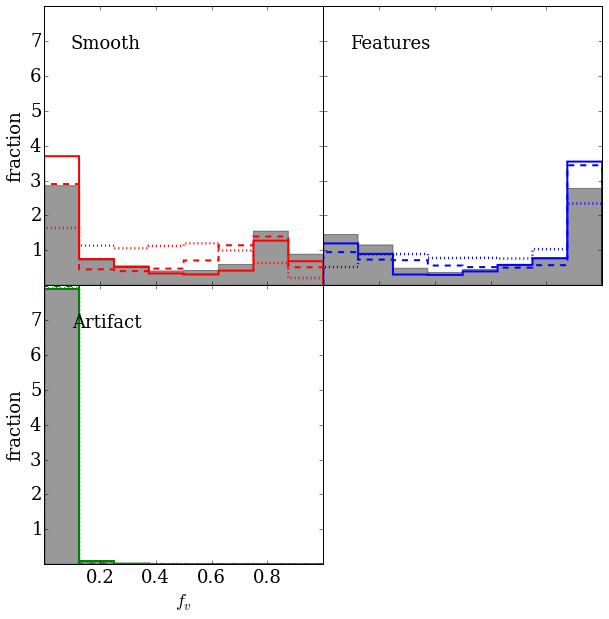

In [15]:
clrs = ['red','blue','green','magenta','orange','purple']

volume_ok = data['in_volume_limit'] == 1
low_z = (data['REDSHIFT_1'] >= 0.03) & (data['REDSHIFT_1'] < 0.035)
high_z = (data['REDSHIFT_1'] >= 0.08) & (data['REDSHIFT_1'] < 0.085)

fig,axarr = make_axes(n_morph,xlabel='$f_v$',ylabel='fraction')

log_y = False

for n,answer in enumerate(answers):
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)

    reference_data = data[question + '_' + answer + '_weighted_fraction'][(volume_ok) & (low_z)]
    w13_data = data[question + '_' + answer + '_debiased'][(volume_ok) & (high_z)]
    h16_data = data[question + '_' + answer +'_debiased_rh'][(volume_ok) & (high_z)]
    h16_norm = data[question + '_' + answer +'_debiased_rh_normalised'][(volume_ok) & (high_z)]
    
    h16_fit = debiased['fit_method'][select]
    h16_bin = debiased['bin_method'][select]
    
    h16_fit = h16_fit[(volume_ok) & (high_z)]
    h16_bin = h16_bin[(volume_ok) & (high_z)]

    bins = np.linspace(0,1,9)

    _ = axarr[n].hist(reference_data,bins=bins,histtype='stepfilled',color='k',alpha=0.4,normed=True)
    _ = axarr[n].hist(h16_data,bins=bins,histtype='step',color=clrs[n],linewidth=2,linestyle='solid',normed=True)
    _ = axarr[n].hist(h16_fit,bins=bins,histtype='step',color=clrs[n],linewidth=2,linestyle='dashed',normed=True)
    _ = axarr[n].hist(w13_data,bins=bins,histtype='step',color=clrs[n],linewidth=2.5,linestyle='dotted',normed=True)
    
    axarr[n].text(0.1,0.9,answerlabels[n],ha='left',va='top',transform=axarr[n].transAxes)
    
    if log_y == True:
        axarr[n].set_yscale('log')
        
#axarr[n].set_ylim(0,4)
    
# solid = our method
# dashed = our method (normalised)
# dotted = willett+ 2013
# grey = low redshift comparison

In [16]:
# k vs kfit, c vs cfit plots:

def plot_fits(a,ax,x='k',y='kf',question=question,questions=questions):
    
    label = questions[question]['answerlabels'][a]
    answer = questions[question]['answers'][a]
    
    plt.sca(ax)
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)

    z = fit_results['redshift']

    plt.scatter(fit_results[x],fit_results[y],c=z,cmap=plt.cm.coolwarm,lw=0,s=50)

    # get axes:
    x_lower,x_upper = ax.get_xlim()
    y_lower,y_upper= ax.get_ylim()

    limits = [np.min([x_lower,y_lower]),np.min([x_upper,y_upper])]
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.plot(limits,limits,'k-')
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    cbar = plt.colorbar()
    
    ax.text(0.05,0.95,label,ha='left',va='top',transform=ax.transAxes)
    
    return None


def plot_kc_fit(a):
    fig,axarr = plt.subplots(1,2,figsize=(15,5))
    axarr = axarr.ravel()
    plot_fits(a,ax=axarr[0])
    plot_fits(a,ax=axarr[1],x='c',y='cf')
    return None

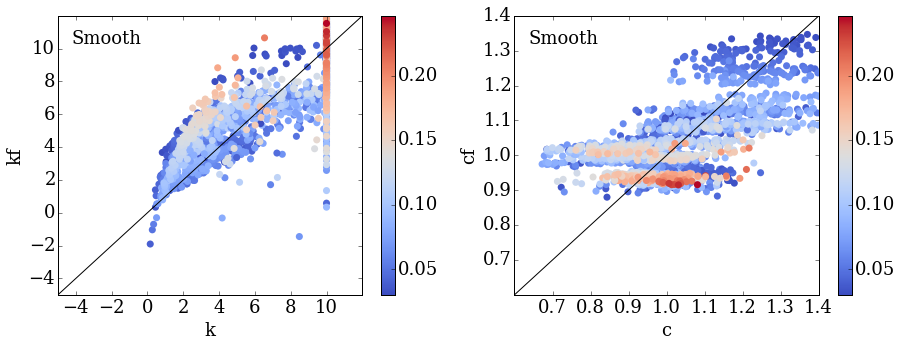

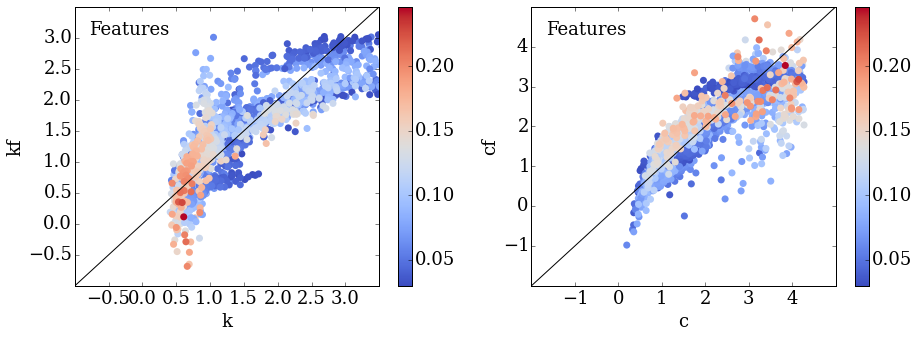

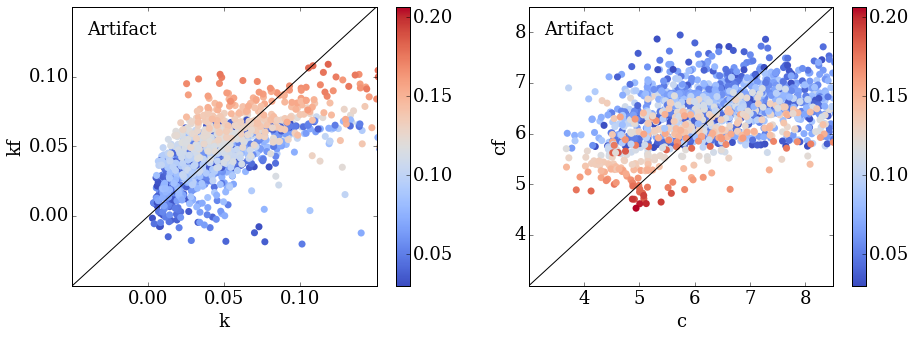

In [17]:
for a in range(len(questions[question]['answers'])):
    plot_kc_fit(a)

In [18]:
def raw_debiased_scatter(full_data,question=question,questions=questions,volume_limit=True,method='fit',Np=10**5):
    
    N = len(questions[question]['answers'])
    fig,axarr = make_axes(n_morph=N,xlabel='$f_v(raw)$'
                          ,ylabel='$f_v({{{}}})$'.format(method))
    labels = questions[question]['answerlabels']
    
    if volume_limit == True:
        vl_select = full_data['in_volume_limit'] == 1
    else:
        vl_select = np.ones(len(full_data))
        vl_select = vl_select == 1
    
    data,select = reduce_sample(full_data,questions,question)
    random.shuffle(data)
    N_sel = np.arange(0,Np)
    
    vl = full_data[(vl_select) & (select)]
    z = vl['REDSHIFT_1']
    
    for m,answer in enumerate(questions[question]['answers']):
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        debiased_plot = debiased[method + '_method'][(vl_select) & (select)]
        raw_plot = vl[question + '_' + answer + '_weighted_fraction']
        
        plt.sca(axarr[m])
        plt.scatter(raw_plot,debiased_plot,c=z,cmap=plt.cm.coolwarm,lw=0,s=20)
        axarr[m].text(0.1,0.9,labels[m],ha='left',va='top',transform=axarr[m].transAxes)
        axarr[m].set_xlim(0,1)
        axarr[m].set_ylim(0,1)
        
    return None

In [ ]:
raw_debiased_scatter(full_data,method='fit',volume_limit=True)
raw_debiased_scatter(full_data,method='bin',volume_limit=True)

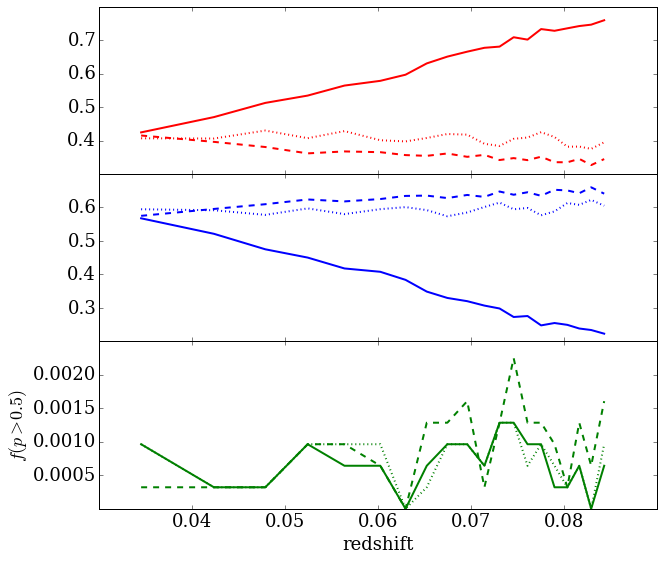

In [27]:
# Redshift trends:
from scipy.stats import binned_statistic

fig,axarr = make_axes(n_morph=len(answers),sharex=True,sharey=False,stack=True)

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

N_b = 20

vl = data[volume_ok]
redshifts = vl['REDSHIFT_1']
x,bins = bin_by_column(redshifts,nbins=N_b)

morph_cut = 0.5

for n,answer in enumerate(answers):

    reference_data = vl[question + '_' + answer + '_weighted_fraction']
    w13_data = vl[question + '_' + answer + '_debiased']
    h16_data = vl[question + '_' + answer +'_debiased_rh_normalised']
    
    deb_fracs = np.zeros(N_b)
    raw_fracs = np.zeros(N_b)
    w13_fracs = np.zeros(N_b)

    for m,b in enumerate(np.unique(bins)):
    
        bin_deb = h16_data[bins == b]
        bin_raw = reference_data[bins == b]
        bin_w13 = w13_data[bins == b]
    
        raw_fracs[m] = np.sum(bin_raw > morph_cut)/len(bin_raw)
        deb_fracs[m] = np.sum(bin_deb > morph_cut)/len(bin_deb)
        w13_fracs[m] = np.sum(bin_w13 > morph_cut)/len(bin_w13)
    
    axarr[n].plot(x,raw_fracs,linestyle='solid',linewidth=2,color=clrs[n],label=labels[n])
    axarr[n].plot(x,deb_fracs,linestyle='dashed',linewidth=2,color=clrs[n],label=labels[n])
    axarr[n].plot(x,w13_fracs,linestyle='dotted',linewidth=2,color=clrs[n],label=labels[n])
    
#plt.ylim(0,1)
plt.ylabel('$f(p>{{{}}})$'.format(morph_cut))
plt.xlabel('redshift')

1(raw) = 40667
1(deb) = 22592
2(raw) = 21553
2(deb) = 39628


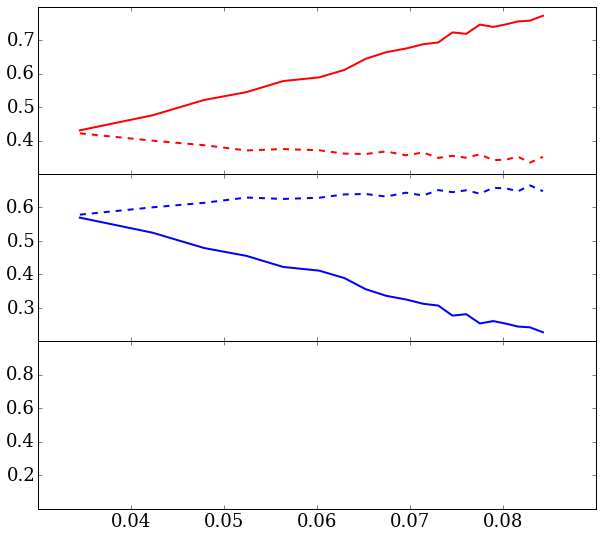

In [28]:
# check sample sizes?

arm_columns_deb = np.array([vl[question + '_' + answer + '_debiased_rh'] for answer in answers[:-1]]).T
arm_columns_raw = np.array([vl[question + '_' + answer + '_weighted_fraction'] for answer in answers[:-1]]).T
# go to answers[-1] (ignore can't tells)
assign_deb = np.argmax(arm_columns_deb,axis=1)
assign_raw = np.argmax(arm_columns_raw,axis=1)

fig,axarr = make_axes(n_morph=len(answers),sharex=True,sharey=False,stack=True)

for p,m in enumerate(np.unique(assign_deb)):
    
    deb_m = np.sum(assign_deb == m)
    raw_m = np.sum(assign_raw == m)
    
    print('{}(raw) = {}'.format(m+1,raw_m))
    print('{}(deb) = {}'.format(m+1,deb_m))
    
    deb_fracs = np.zeros(N_b)
    raw_fracs = np.zeros(N_b)
    w13_fracs = np.zeros(N_b)

    for n,b in enumerate(np.unique(bins)):
    
        bin_deb = assign_deb[bins == b]
        bin_raw = assign_raw[bins == b]
    
        deb_fracs[n] = np.sum(bin_deb == m)/len(bin_deb)
        raw_fracs[n] = np.sum(bin_raw == m)/len(bin_raw)
    
    axarr[p].plot(x,raw_fracs,linestyle='solid',linewidth=2,color=clrs[p],label=labels[p])
    axarr[p].plot(x,deb_fracs,linestyle='dashed',linewidth=2,color=clrs[p],label=labels[p])